# Exercise Week 9: Pruning and Quantization
This week, we will explore some of the ideas discussed in Han, Mao, and Dally's Deep Compression.  In particular, we will implement weight pruning with fine tuning, as well as k-means weight quantization.  **Note that we will unfortunately not be doing this in a way that will actually lead to substantial efficiency gains: that would involve the use of sparse matrices which are not currently well-supported in pytorch.** 

## Training an MNIST classifier
For this example, we'll work with a basic multilayer perceptron with a single hidden layer.  We will train it on the MNIST dataset so that it can classify handwritten digits.  As usual we load the data:

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

batch_size = 300
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Then define a model:

In [2]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,mask=None):
        super(MultilayerPerceptron, self).__init__()
        if not mask:
            self.mask = torch.nn.Parameter(torch.ones(input_dim,hidden_dim),requires_grad=False)
        else:
            self.mask = torch.nn.Parameter(mask)

        self.W_0 = torch.nn.Parameter(1e-3*torch.randn(input_dim,hidden_dim)*self.mask,requires_grad=True)
        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim),requires_grad=True)

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim),requires_grad=True)
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim),requires_grad=True)
        
    def set_mask(self,mask):
        
        self.mask.data = mask.data
        self.W_0.data = self.mask.data*self.W_0.data

    def forward(self, x):
        hidden = torch.tanh(x@(self.W_0*self.mask) + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs


Note that the above code is a little bit different than a standard multilayer perceptron implementation.

### Q1: What does this model have the capability of doing that a "Vanilla" MLP does not.  Why might we want this functionality for studying pruning?

### Answer 
---
It sets up a "mask" Parameter field and a set_mask() method. These two in combination allow us to set W_0 
to a tensor with 1's that doesnt have gradient functionality. THis should effectivly prune the weights set 
to 1. They value of 1 provides identity functionality for the forward pass and the requires_grad=False will 
prevent it from being used in back propigation. 

---

Let's first train this model without utilizing this extra functionality.  You can set the hidden layer size to whatever you'd like when instantiating the model:

In [3]:
n_epochs = 10

input_dim = 784
hidden_dim = 64
output_dim = 10

model = MultilayerPerceptron(input_dim,hidden_dim,output_dim)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
lr_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate, weight_decay=1e-3)

And then training proceeds as normal.

In [4]:
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_pretrained.h5')


Iteration: 0. Loss: 0.3774052560329437. Accuracy: 90.
Iteration: 1. Loss: 0.31951141357421875. Accuracy: 92.
Iteration: 2. Loss: 0.2256118804216385. Accuracy: 93.
Iteration: 3. Loss: 0.20053575932979584. Accuracy: 94.
Iteration: 4. Loss: 0.21205347776412964. Accuracy: 94.
Iteration: 5. Loss: 0.1701248288154602. Accuracy: 95.
Iteration: 6. Loss: 0.12101459503173828. Accuracy: 95.
Iteration: 7. Loss: 0.13630355894565582. Accuracy: 95.
Iteration: 8. Loss: 0.12906600534915924. Accuracy: 95.
Iteration: 9. Loss: 0.1394767165184021. Accuracy: 95.


## Pruning

Certainly not a state of the art model, but also not a terrible one.  Because we're hoping to do some weight pruning, let's inspect some of the weights directly (recall that we can act like they're images)

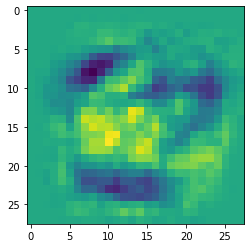

In [5]:
import matplotlib.pyplot as plt
W_0 = model.W_0.detach().cpu().numpy()
plt.imshow(W_0[:,1].reshape((28,28)))
plt.show()

### Q2: Based on the above image, what weights might reasonably be pruned (i.e. explicitly forced to be zero)?

### Answer
---
The most reasonable weight to prune would be the weight at the peripheries of the image with low values.

### Q3: Implement some means of establishing a threshold for the (absolute value of the) weights, below which they are set to zero.  Using this method, create a mask array.     

### Answer
---
$$ -0.1 < W^0 < 0.1$$ 

In [6]:
for i in range(input_dim):
    for j in range(hidden_dim):
        if (model.W_0[i][j] < 0.1) and (model.W_0[i][j] > -0.1):
            model.mask[i][j] = 0
            
new_mask = model.mask

Now that we have a mask that explicitly establishes a sparsity pattern for our model, let's update our model with this mask:

In [7]:
model.set_mask(new_mask)

Now, we have explicitly set some entries in one of the the weight matrices to zero, and ensured via the mask, that they will not be updated by gradient descent.  Fine tune the model: 

In [8]:
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_pruned.h5')

Iteration: 0. Loss: 0.23306943476200104. Accuracy: 93.
Iteration: 1. Loss: 0.25122612714767456. Accuracy: 94.
Iteration: 2. Loss: 0.21719975769519806. Accuracy: 94.
Iteration: 3. Loss: 0.1498088836669922. Accuracy: 94.
Iteration: 4. Loss: 0.1789630949497223. Accuracy: 94.
Iteration: 5. Loss: 0.1626765877008438. Accuracy: 94.
Iteration: 6. Loss: 0.15591850876808167. Accuracy: 95.
Iteration: 7. Loss: 0.18140427768230438. Accuracy: 95.
Iteration: 8. Loss: 0.16337290406227112. Accuracy: 95.
Iteration: 9. Loss: 0.1745852530002594. Accuracy: 95.


### Q4: How much accuracy did you lose by pruning the model?  How much "compression" did you achieve (here defined as total entries in W_0 divided by number of non-zero entries)?  

### Answer
---
I did not loose any accuracy and got 54x compression. 

In [12]:
total_zero = 0
non_zero = 0
for i in range(input_dim):
    for j in range(hidden_dim):
        if model.W_0[i][j] == 0:
            total_zero += 1
        else:
            non_zero += 1
total_weights = total_zero + non_zero
compression = input_dim * hidden_dim / total_zero
print("Compression: %.0fx" % compression)

Compression: 56x


### Q5: Explore a few different thresholds: approximately how many weights can you prune before accuracy starts to degrade?

### Answer
---
The number of weight I could prune deepened on how incrementally I increased the cut off point. Smaller 
increments resulted in maintained accuracy while still reducing the number of weights. 

In [10]:
for i in range(input_dim):
    for j in range(hidden_dim):
        if (model.W_0[i][j] < 0.4) and (model.W_0[i][j] > -0.4):
            model.mask[i][j] = 0

new_mask = model.mask
model.set_mask(new_mask)

iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_pruned.h5')

total_zero = 0
for i in range(input_dim):
    for j in range(hidden_dim):
        if model.W_0[i][j] == 0:
            total_zero += 1


print("Number of Zero Weights: %d" % total_zero)

Iteration: 0. Loss: 0.9962528347969055. Accuracy: 72.
Iteration: 1. Loss: 0.8117055892944336. Accuracy: 75.
Iteration: 2. Loss: 0.7685936689376831. Accuracy: 77.
Iteration: 3. Loss: 0.7300627827644348. Accuracy: 78.
Iteration: 4. Loss: 0.6702426671981812. Accuracy: 78.
Iteration: 5. Loss: 0.6452513337135315. Accuracy: 79.
Iteration: 6. Loss: 0.7629560232162476. Accuracy: 79.
Iteration: 7. Loss: 0.6346336603164673. Accuracy: 79.
Iteration: 8. Loss: 0.6131376028060913. Accuracy: 80.
Iteration: 9. Loss: 0.5354604125022888. Accuracy: 79.
Number of Zero Weights: 11195


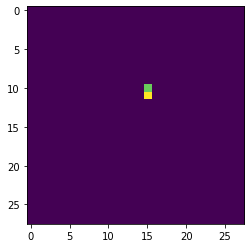

In [11]:
W_0 = model.W_0.detach().cpu().numpy()
plt.imshow(W_0[:,1].reshape((28,28)))
plt.show()

## Quantization

Now that we have a pruned model that appears to be performing well, let's see if we can make it even smaller by quantization.  To do this, we'll need a slightly different neural network, one that corresponds to Figure 3 from the paper.  Instead of having a matrix of float values, we'll have a matrix of integer labels (here called "labels") that correspond to entries in a (hopefully) small codebook of centroids (here called "centroids").  The way that I've coded it, there's still a mask that enforces our desired sparsity pattern.

In [13]:
class MultilayerPerceptronQuantized(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim,mask,labels,centroids):
        super(MultilayerPerceptronQuantized, self).__init__()
        self.mask = torch.nn.Parameter(mask,requires_grad=False)
        self.labels = torch.nn.Parameter(labels,requires_grad=False)
        self.centroids = torch.nn.Parameter(centroids,requires_grad=True)

        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim))

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim))
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        W_0 = self.mask*self.centroids[self.labels]
        hidden = torch.tanh(x@W_0 + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs

Notice what is happening in the forward method: W_0 is being reconstructed by using a matrix (self.labels) to index into a vector (self.centroids).  The beauty of automatic differentiation allows backpropogation through this sort of weird indexing operation, and thus gives us gradients of the objective function with respect to the centroid values!

### Q6: However, before we are able to use this AD magic, we need to specify the static label matrix (and an initial guess for centroids).  Use the k-means algorithm (or something else if you prefer) figure out the label matrix and centroid vectors.  PROTIP1: I used scikit-learns implementation of k-means.  PROTIP2: only cluster the non-zero entries

In [32]:
import numpy as np
from sklearn import cluster as cl

# convert weight and mask matrices into numpy arrays
W_0 = model.W_0.detach().cpu().numpy()
mask = model.mask.detach().cpu().numpy()

# Figure out the indices of non-zero entries 
inds = np.where(mask!=0)
# Figure out the values of non-zero entries
vals = W_0[inds]

### TODO: perform clustering on vals
kmeans = cl.KMeans(4).fit(vals.reshape(-1,1))
cent = kmeans.cluster_centers_


### TODO: turn the label matrix and centroids into a torch tensor
labels = torch.tensor(np.arange(0,3),dtype=torch.long,device=device)
centroids = torch.tensor(kmeans.cluster_centers_ ,device=device)

Now, we can instantiate our quantized model and import the appropriate pre-trained weights for the other network layers.  

In [23]:
# Instantiate quantized model
model_q = MultilayerPerceptronQuantized(input_dim,output_dim,hidden_dim,new_mask,labels,centroids)
model_q = model_q.to(device)

# Copy pre-trained weights from unquantized model for non-quantized layers
model_q.b_0.data = model.b_0.data
model_q.W_1.data = model.W_1.data
model_q.b_1.data = model.b_1.data

Finally, we can fine tune the quantized model.  We'll adjust not only the centroids, but also the weights in the other layers.

In [24]:
optimizer = torch.optim.Adam(model_q.parameters(), lr=lr_rate, weight_decay=1e-3)
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_q(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model_q(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_quantized.h5')

RuntimeError: The size of tensor a (784) must match the size of tensor b (3) at non-singleton dimension 0

After retraining, we can, just for fun, reconstruct the pruned and quantized weights and plot them as images:

In [ ]:
W_0 = (model_q.mask*model_q.centroids[model_q.labels]).detach().cpu().numpy()
plt.imshow(W_0[:,1].reshape((28,28)))
plt.show()

Certainly a much more parsimonious representation.  The obvious question now becomes:

### Q7: How low can you go?  How small can the centroid codebook be before we see a substantial degradation in test set accuracy?

### Bonus question: Try establishing the sparsity pattern using a model that's only been trained for a single epoch, then fine tune the pruned model and quantize as normal.  How does this compare to pruning a model that has been fully trained?  